In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime

import sys
sys.path.insert(1, '../hydro-requirement')
import hydrogen as h2

def get_prediction(syear, stime, elec, fut, plotflag, title, name=0):
    """
    Parameters:
    -----------
    - syear: [int]
    data used for the prediction starts at 'syear' and
    ends at last year.
    - stime: [list]
    list of years of the electricity generation data.
    - elec: [list]
    list of electricity generation data.
    - fut: [int]
    number of years to do the prediction for.
    - plotflag: [bool]
    False: no plotting.
    Returns:
    --------
    - future: [list]
    years of the prediction.
    - ytf: [list]
    prediction of electricity generation.
    """
    sstime = stime[stime.index(syear):]
    yt = elec[stime.index(syear):]
    sstime = np.array(sstime).reshape(len(sstime),1)
    yt = np.array(yt)
    lin = LinearRegression()
    lin.fit(sstime, yt)
    # print(r'R$^2$ score: ', lin.score(sstime, yt))
    pt = lin.predict(sstime)
    future = np.arange(fut).reshape(fut, 1) + stime[-1]
    ytf = lin.predict(future)
    
    if plotflag == True:
        plt.figure()
        plt.plot(stime, elec, label='data', marker='*', markersize=4)
        plt.plot(sstime, pt, label='regression', marker='o', markersize=5)
        plt.plot(future, ytf, label='prediction', marker='v', markersize=4)
        plt.legend(loc='upper left')
        plt.xlabel('year')
        plt.ylabel('Million [kWh]')
        plt.title(title+' electricity net generation.')
        plt.savefig("figures/"+name, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
    return future, ytf


def electricity(mass):
    """
    Energy produced from H2.
    60% efficiency from DOE fuelcell factsheet.
    Parameters:
    -----------
    mass: hydrogen mass [kg]
    Returns:
    --------
    E: electrical energy [kWh]
    """
    # ~285kJ/mol = ~40kWh/kg-H2
    E = 0.6*40*mass
    return E

# US demand and solar generation prediction

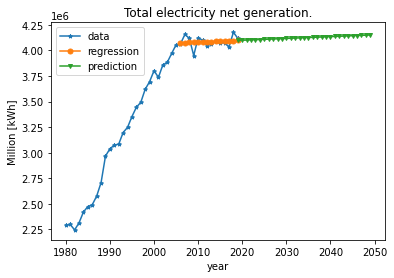

In 2050 the total demand will be 4151117.127683516 10$^6$ kWh


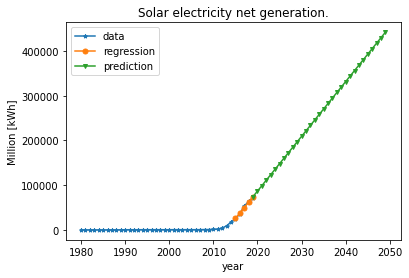

In 2050 the solar generation will be 441910.62459999695 10$^6$ kWh
ustg: 1.0080296613830406
ussg: 6.117750091528658


In [2]:
df = pd.read_csv ('electricity-year.csv')
time = df['Annual Total'].tolist()
total = df["Electricity Net Generation Total (including from sources not shown), All Sectors (Million Kilowatthours)"].tolist()
solar = df["Electricity Net Generation From Solar, All Sectors (Million Kilowatthours)"].tolist()

for i in range(len(solar)):
    if solar[i] == 'Not Available':
        solar[i] = 0
    else:
        solar[i] = float(solar[i])

zyear = 1980
ztime = time[time.index(zyear):]
ztotal = total[time.index(zyear):]
zsolar = solar[time.index(zyear):]

predict = 31
future1, ytf1 = get_prediction(2006, ztime, ztotal, predict, True, 'Total', 'us-prediction1')
print('In {0} the total demand will be {1} 10$^6$ kWh'.format(2019+predict, ytf1[-1]))
future2, ytf2 = get_prediction(2015, ztime, zsolar, predict, True, 'Solar', 'us-prediction2')
print('In {0} the solar generation will be {1} 10$^6$ kWh'.format(2019+predict, ytf2[-1]))

ustg = ytf1[-1]/ztotal[-1]
print('ustg:', ustg)
ussg = ytf2[-1]/zsolar[-1]
print('ussg:', ussg)

## Duck curve US

max occurs at 4/17/2019 2 p.m. EDT
min total-solar:  277074.1914444006 13
max total-solar:  427937.8743909742 22
max solar:  148220.84921755633 14


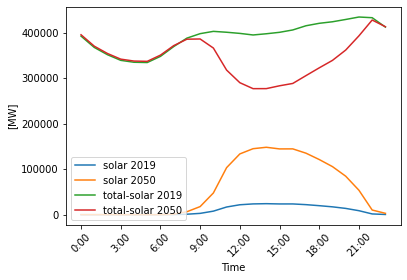

In [5]:
df = pd.read_csv ('us-hourly3.csv')
time = df['Timestamp (Hour Ending)'].tolist()
solar = df['Solar Generation (MWh)'].tolist()
nuclear = df['Nuclear Generation (MWh)'].tolist()
total = df['Total Generation (MWh)'].tolist()

time_max = time[solar.index(max(solar))]
print('max occurs at {0}'.format(time_max))

# choose date and time
sdate = '4/17/2019'
stime = '12 a.m. EDT'
edate = '4/18/2019'
etime = '12 a.m. EDT'

s = time.index(sdate+' '+stime)
e = time.index(edate+' '+etime)

ntime = time[s:e]
nsolar = np.array(solar[s:e])
ntotal = np.array(total[s:e])

ntime = [str(i)+':00' for i in range(24)]

plt.figure()
nntotal = ustg*ntotal
plt.plot(ntime, nsolar, label='solar 2019')
nnsolar = ussg*nsolar
plt.plot(ntime, nnsolar, label='solar {0}'.format(2019+predict))
plt.plot(ntime, ntotal-nsolar, label='total-solar 2019')
plt.plot(ntime, nntotal-nnsolar, label='total-solar {0}'.format(2019+predict))

plt.xticks(np.arange(0, 24, step=3), rotation=45)
#plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True)
plt.legend(loc="lower left")
plt.ylabel('[MW]')
plt.xlabel('Time')
# plt.title('Prediction on US demand in the US for 2050.')
plt.savefig("figures/us-duck", dpi=300, bbox_inches="tight")

print('min total-solar: ', np.min(nntotal-nnsolar), (nntotal-nnsolar).tolist().index(np.min(nntotal-nnsolar)))
print('max total-solar: ', np.max(nntotal-nnsolar), (nntotal-nnsolar).tolist().index(np.max(nntotal-nnsolar)))
print('max solar: ', np.max(nnsolar), nnsolar.tolist().index(np.max(nnsolar)))

## UIUC duck curve

min total-solar:  14982.65474172451 11
max total-solar:  46888.76639545371 17
max solar:  28514.833176615073 11
diff max-min:  31906.111653729204


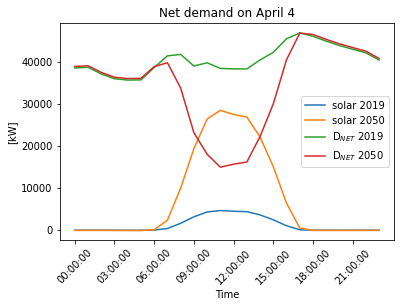

In [8]:
df = pd.read_csv('2015-2019-uiuc-solar.csv')

timeh = df['time'].tolist()
solarh = df['measured'].tolist()

s = timeh.index('2018-10-03 00:00:00')
e = timeh.index('2019-10-03 23:45:00')
timev = timeh[s:e+1]
solarv = solarh[s:e+1]
time_max = timev[solarv.index(max(solarv))]
day = datetime.fromisoformat(time_max)
s = timev.index(str(day.date())+' 00:00:00')
e = timev.index(str(day.date())+' 23:45:00')
timed = timev[s:e+1]
valsol = solarv[s:e+1]

df = pd.read_csv('2014-2019-uiuc-electricity-demand.csv')

timeh = df['time'].tolist()
totalh = df['kw'].tolist()

s = timeh.index(str(day.date())+' 00:00:00')
e = timeh.index(str(day.date())+' 23:00:00')
timed = timeh[s:e+1]
valtot = np.array(totalh[s:e+1])

A = np.zeros((len(valtot), len(valsol)))
for i in range(A.shape[0]):
    A[i, 4*i:4*(i+1)] = 0.25*np.ones(4)
nvalsol = A @ np.array(valsol)

timep = [str(datetime.fromisoformat(timed[i]).time()) for i in range(len(timed))]

plt.plot(timep, nvalsol, label='solar 2019')
nnvalsol = ussg*nvalsol
plt.plot(timep, nnvalsol, label='solar 2050')

totmsol = valtot-nvalsol
plt.plot(timep, totmsol, label='D$_{NET}$ 2019')
nvaltot = ustg*valtot
ntotmsol = nvaltot-nnvalsol
plt.plot(timep, ntotmsol, label='D$_{NET}$ 2050')

plt.xticks(np.arange(0, 24, step=3), rotation=45)
plt.ylabel('[kW]')
plt.xlabel('Time')
# plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
#plt.legend(loc="lower left")
plt.legend(loc="best")
plt.title("Net demand on April 4", color="black")

plt.savefig("figures/uiuc-duck", dpi=300, bbox_inches="tight")

print('min total-solar: ', np.min(ntotmsol), ntotmsol.tolist().index(np.min(ntotmsol)))
print('max total-solar: ', np.max(ntotmsol), ntotmsol.tolist().index(np.max(ntotmsol)))
print('max solar: ', np.max(nnvalsol), nnvalsol.tolist().index(np.max(nnvalsol)))
print('diff max-min: ', (np.max(ntotmsol)-np.min(ntotmsol)))

## H2 production

P$_{th}$ =  75.75757575757576 MW
$\eta$ = 0.4983437221727516%
P$_{th}$ =  50.16617825745122 MW
total h2 produced w/ LTE:  660.1208045109594 kg/day
total h2 produced w/ HTE:  1128.518878933839 kg/day
total h2 produced w/ SI:  815.1566264750497 kg/day


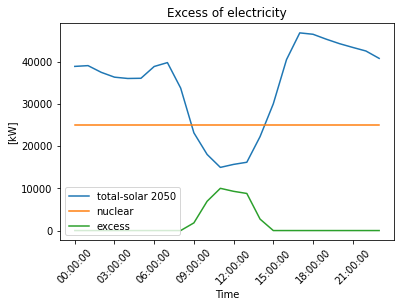

<Figure size 432x288 with 0 Axes>

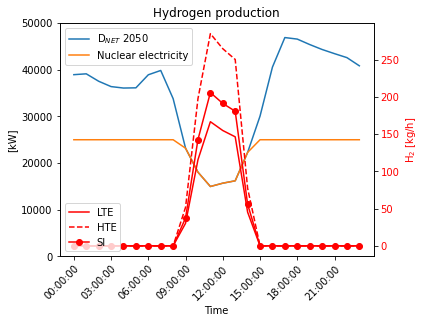

In [6]:
reactor_size = 25e3  # kW
reactor = reactor_size*np.ones(len(nvalsol))
h2energy = reactor-ntotmsol
h2energy[h2energy < 0] = 0

plt.figure(1)
plt.plot(timep, ntotmsol, label='total-solar {0}'.format(2019+predict))
plt.plot(timep, reactor, label='nuclear')
plt.plot(timep, h2energy, label='excess')
#plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
plt.legend(loc="lower left")
plt.xticks(np.arange(0, 24, step=3), rotation=45)
plt.ylabel('[kW]')
plt.xlabel('Time')
plt.title('Excess of electricity')
plt.savefig("figures/uiuc-hydro1", dpi=300, bbox_inches="tight")

PE = reactor-h2energy  # [kWh]
beta = PE/reactor_size  # \eta \beta P_{th} / \eta P_{th}

eta1 = 0.33
Pth1 = reactor_size/eta1/1e3  # [MW_{th}]
print('P$_{th}$ = ', Pth1, 'MW')
h2prod1 = h2.lte_prod_rate((1-beta)*Pth1, eta1)[0]

p = 3.5
p *= 9.86923  # MPa -> atm
tout = 850
eta2 = h2.efficiency(tout)
print('$\eta$ = {0}%'.format(eta2))
Pth2 = reactor_size/eta2/1e3  # [MW_{th}]
print('P$_{th}$ = ', Pth2, 'MW')
h2prod2 = [h2.hte_prod_rate((1-be)*Pth2, p, tout)[0] for be in beta]

tout = 850
h2prod3 = [h2.si_prod_rate((1-be)*Pth2, tout)[0] for be in beta]

plt.figure(2)
fig, ax1 = plt.subplots()
# ax1.plot(timep, ntotmsol, label='total-solar {0}'.format(2019+predict))
ax1.plot(timep, ntotmsol, label='D$_{NET}$ 2050')
ax1.plot(timep, PE, label='Nuclear electricity')
# ax1.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
ax1.legend(loc="upper left")
ax1.set_title("Hydrogen production", color="black")
ax1.set_ylabel('[kW]', color="black")
ax1.set_ylim(0, 50e3) 

ax2 = ax1.twinx()
ax2.plot(timep, h2prod1, label='LTE', color='red')
ax2.plot(timep, h2prod2, '--', label='HTE', color='red')
ax2.plot(timep, h2prod3, '-o', label='SI', color='red')
# ax2.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
ax2.legend(loc="lower left")

ax2.set_ylabel('H$_2$ [kg/h]', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()

timelabel = []
for i in range(0, 24, 3):
    timelabel.append(timep[i])

ax1.set_xticklabels(timelabel)
ax1.set_xticks(timelabel)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax1.set_xlabel('Time')
plt.savefig("figures/uiuc-hydro2B", dpi=300, bbox_inches="tight")

total1 = sum(h2prod1)
print('total h2 produced w/ LTE: ', total1, 'kg/day')
total2 = sum(h2prod2)
print('total h2 produced w/ HTE: ', total2, 'kg/day')
total3 = sum(h2prod3)
print('total h2 produced w/ SI: ', total3, 'kg/day')

We suppose 60% efficient, the fuel cells. See [ref](https://www.californiahydrogen.org/wp-content/uploads/files/doe_fuelcell_factsheet.pdf).

15842.9 kWh/day
27084.45 kWh/day
19563.76 kWh/day
level1:  41889.65896713171
level2:  40016.066669440195
level3:  41269.51567927535
sanity check 1:  15081.795216217026
sanity check 2:  24683.48909424572
sanity check 3:  18213.51881989168
peak reduction 1: 4999.1074283220005 kW
peak reduction 2: 6872.699726013518 kW
peak reduction 3: 5619.250716178365 kW


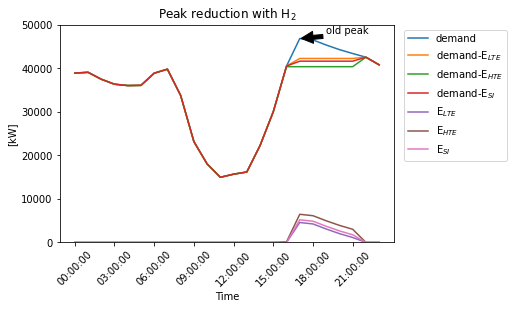

In [7]:
elect1 = electricity(total1)
elect2 = electricity(total2)
elect3 = electricity(total3)
print(round(elect1, 2), 'kWh/day')
print(round(elect2, 2), 'kWh/day')
print(round(elect3, 2), 'kWh/day')

sdistribute = '16:00:00'
s = timep.index(sdistribute)
distribute = 6

level1 = (sum(ntotmsol[s:s+distribute])-elect1)/distribute
print("level1: ", level1)
level2 = (sum(ntotmsol[s:s+distribute])-elect2)/distribute
print("level2: ", level2)
level3 = (sum(ntotmsol[s:s+distribute])-elect3)/distribute
print("level3: ", level3)

new_tot_sol1 = ntotmsol.copy()
new_tot_sol2 = ntotmsol.copy()
new_tot_sol3 = ntotmsol.copy()
new_hydro_elect1 = np.zeros(len(ntotmsol))
new_hydro_elect2 = np.zeros(len(ntotmsol))
new_hydro_elect3 = np.zeros(len(ntotmsol))
for i in range(s, s+distribute):
    if new_tot_sol1[i] >= level1*1.01:
        new_tot_sol1[i] = level1*1.01
        new_hydro_elect1[i] = ntotmsol[i]-new_tot_sol1[i]
    if new_tot_sol2[i] >= level2*1.01:
        new_tot_sol2[i] = level2*1.01
        new_hydro_elect2[i] = ntotmsol[i]-new_tot_sol2[i]
    if new_tot_sol3[i] >= level3*1.01:
        new_tot_sol3[i] = level3*1.01
        new_hydro_elect3[i] = ntotmsol[i]-new_tot_sol3[i]
        
print('sanity check 1: ', sum(new_hydro_elect1))
print('sanity check 2: ', sum(new_hydro_elect2))
print('sanity check 3: ', sum(new_hydro_elect3))

opeak = max(ntotmsol)
# print('old peak:', opeak)
find = ntotmsol.tolist().index(max(ntotmsol))
# print('new peak1:', level1)
print('peak reduction 1:', opeak-level1, 'kW')
# print('new peak2:', level2)
print('peak reduction 2:', opeak-level2, 'kW')
# print('new peak3:', level3)
print('peak reduction 3:', opeak-level3, 'kW')

plt.plot(timep, ntotmsol, label = 'demand')
plt.plot(timep, new_tot_sol1, label = 'demand-E$_{LTE}$')
plt.plot(timep, new_tot_sol2, label = 'demand-E$_{HTE}$')
plt.plot(timep, new_tot_sol3, label = 'demand-E$_{SI}$')
plt.plot(timep, new_hydro_elect1, label = 'E$_{LTE}$')
plt.plot(timep, new_hydro_elect2, label = 'E$_{HTE}$')
plt.plot(timep, new_hydro_elect3, label = 'E$_{SI}$')

plt.xticks(np.arange(0, 24, step=3), rotation=45)
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0), fancybox=True)
# plt.legend(loc="lower left")
plt.annotate('old peak', xy=(find, opeak), xytext=(find+2, opeak+1e3),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylim(0, 50e3)
plt.ylabel('[kW]')
plt.xlabel('Time')
plt.title('Peak reduction with H$_2$')
plt.savefig("figures/uiuc-hydro3", dpi=300, bbox_inches="tight")